In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pytensor.tensor as T

Let's suppose that we have three variables, $x,y,z$. The underlying relationships are:
$$
\begin{aligned}
&y = \beta_1 \times x + \beta_0 + \epsilon_1\\
&z = \beta_3 \times y - \beta_2 + \epsilon_2\\
&\epsilon_1 \sim \mathcal{N}(0,\sigma_0)\\
&\epsilon_2 \sim \mathcal{N}(0,\sigma_1)\\
\end{aligned}
$$
where
$\beta_0=1, \beta_1=1, \beta_2=-1, \beta_3=1, \sigma_0=1, \sigma_0=1$.

In [43]:
# generate data
np.random.seed(134)
N=100
x = np.random.rand(N) * 2 - 1
y = 1 * x + 1 + np.random.randn(N)
z = 1 * y - 1 + np.random.randn(N)

Assuming we do not know the underlying functions, our objective is to estimate the posterior distribution of the model parameters $\boldsymbol{\uptheta}=(\beta_0,\beta_1,\beta_2,\beta_3,\sigma_0,\sigma_1)$:
$$
p(\boldsymbol{\uptheta}|\mathbf{D}) \propto p(\mathbf{D}|\boldsymbol{\uptheta}) p(\boldsymbol{\uptheta})
$$


If there are no missing data, i.e., we have 100 datapoints, estimating the posterior is not a big deal.

In [23]:
model = pm.Model()
with model:
    # Prior
    beta = pm.Normal("beta", mu=0, sigma=10, shape=4)
    sigma = pm.Exponential("sigma", lam=1/100, shape=2)

    # Likelihood
    y_hat = beta[1] * x + beta[0]
    y_obs = pm.Normal("y_obs", mu=y_hat, sigma=sigma[0], observed=y)
    z_hat = beta[3] * y + beta[2]
    z_obs = pm.Normal("z_obs", mu=z_hat, sigma=sigma[1], observed=z)

    # draw 1000 posterior samples
    samples = pm.sample(3000)

beta_samples = samples.posterior['beta'].values.reshape(-1,4)
sigma_samples = samples.posterior['sigma'].values.reshape(-1,2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 62 seconds.


As an example, let us visualize the marginalized posterior for $\beta_2$ and $\beta_3$. <br>
From the figure below, we can see that the posteriors are concentrated at the true values, -1 and 1.

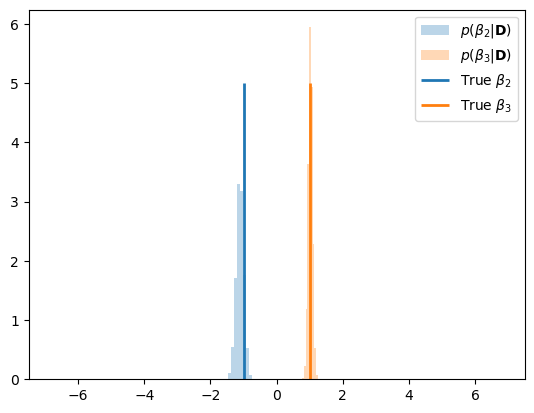

In [95]:
plt.hist(beta_samples[:,2],label='$p(\\beta_2|\\mathbf{D})$',density=True,alpha=0.3)
plt.hist(beta_samples[:,3],label='$p(\\beta_3|\\mathbf{D})$',density=True,alpha=0.3)
plt.vlines(-1,0,5,color='C0', linewidth=2, label='True $\\beta_2$')
plt.vlines(1,0,5,color='C1', linewidth=2, label='True $\\beta_3$')
plt.xlim(-7.5,7.5)
plt.legend()

Now, let us think about a situation where we lost most of the $y$ data. We have only the first 5 datapoints. We still have the full $x$ and $z$ data. If we drop the 95 datapoints because of the missing y values, we will not have enough information to estimate the posterior distribution.

In [40]:
model_5p = pm.Model()
with model_5p:
    # Prior
    beta = pm.Normal("beta", mu=0, sigma=10, shape=4)
    sigma = pm.Exponential("sigma", lam=1/100, shape=2)

    # Likelihood
    y_hat = beta[1] * x[:5] + beta[0]
    y_obs = pm.Normal("y_obs", mu=y_hat, sigma=sigma[0], observed=y[:5])
    z_hat = beta[3] * y[:5] + beta[2]
    z_obs = pm.Normal("z_obs", mu=z_hat, sigma=sigma[1], observed=z[:5])

    # draw 1000 posterior samples
    samples_5p = pm.sample(3000)
beta_samples_5p = samples_5p.posterior['beta'].values.reshape(-1,4)
sigma_samples_5p = samples_5p.posterior['sigma'].values.reshape(-1,2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 79 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


From the figure below, we can see that the posteriors are very flat, i.e., high uncertainty.

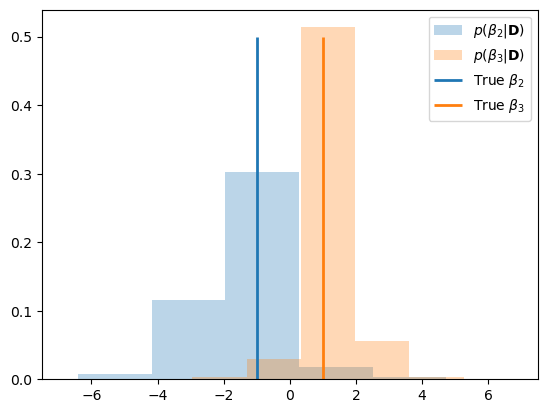

In [94]:
plt.hist(beta_samples_5p[:,2],label='$p(\\beta_2|\\mathbf{D})$',density=True,alpha=0.3)
plt.hist(beta_samples_5p[:,3],label='$p(\\beta_3|\\mathbf{D})$',density=True,alpha=0.3)
plt.vlines(-1,0,0.5,color='C0', linewidth=2, label='True $\\beta_2$')
plt.vlines(1,0,0.5,color='C1', linewidth=2, label='True $\\beta_3$')
plt.xlim(-7.5,7.5)
plt.legend()

Instead of throwing away the 95 datapoints, by introducing latent variables representing missing $y$ values, in the model, we can implement this idea: <br>
*"We don't have the $y$ values. But, we know that $x$ and $z$ are linked through $y$"* <br>
In other words, we can try to maximize the use of the information in the $x$ and $z$ values.

In [31]:
model_latent = pm.Model()
with model_latent:
    # Prior
    beta = pm.Normal("beta", mu=0, sigma=10, shape=4)
    sigma = pm.Exponential("sigma", lam=1/100, shape=2)

    # Likelihood
    y_hat = beta[1] * x + beta[0]
    y_obs = pm.Normal("y_obs", mu=y_hat[:10], sigma=sigma[0], observed=y[:10])
    y_latent = pm.Normal("y_latent", mu=y_hat[10:], sigma=sigma[0])
    y_concat = T.concatenate((y[:10],y_latent))
    
    z_hat = beta[3] * y_concat + beta[2]
    z_obs = pm.Normal("z_obs", mu=z_hat, sigma=sigma[1], observed=z)

    # draw 1000 posterior samples
    samples_latent = pm.sample(3000)
beta_samples_latent = samples_latent.posterior['beta'].values.reshape(-1,4)
sigma_samples_latent = samples_latent.posterior['sigma'].values.reshape(-1,2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma, y_latent]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 82 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


From the figure below, we can see that the posteriors are much better, i.e., much lower uncertainty.

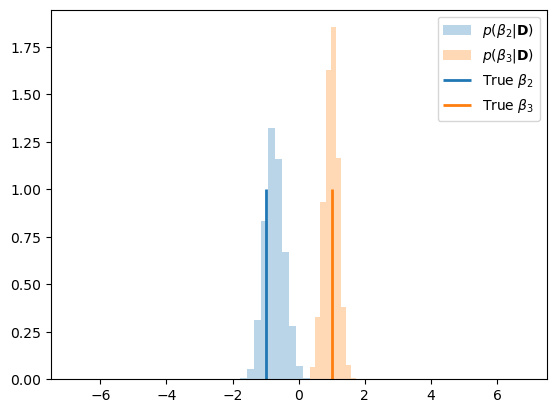

In [100]:
plt.hist(beta_samples_latent[:,2],label='$p(\\beta_2|\\mathbf{D})$',density=True,alpha=0.3)
plt.hist(beta_samples_latent[:,3],label='$p(\\beta_3|\\mathbf{D})$',density=True,alpha=0.3)
plt.vlines(-1,0,1,color='C0', linewidth=2, label='True $\\beta_2$')
plt.vlines(1,0,1,color='C1', linewidth=2, label='True $\\beta_3$')
plt.xlim(-7.5,7.5)
plt.legend()